# Airline Tweets Sentiment Analysis

#### Created By: Kanika Chopra
#### Date: 09/16/2019

In [37]:
from fastai.text import * 
from fastai import *

import pandas as pd
import matplotlib as plt
import numpy as np
import matplotlib.pyplot as plt

In [3]:
path = Path(r"C:\Users\RQ\Documents")

df = pd.read_csv(path/'Tweets.csv')

### Let's take a look at our data
We first begin by looking at the first five pieces of data that we have from the CSV file.

In [4]:
df.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Let's spit this dataframe into our training and validation sets now. We'll then use these separate dataframes to create our DataBunches.

In [5]:
bs = 32

# Language Model
data_lm = TextLMDataBunch.from_csv(path, csv_name = 'Tweets.csv', text_cols='text', valid_pct=0.1, bs=bs)

# Classifier
data_clas = TextClasDataBunch.from_csv(path, csv_name='Tweets.csv', vocab=data_lm.train_ds.vocab, bs=bs, text_cols='text',
                                      label_cols='airline_sentiment')

Let's take a look at our data for the language models and classifier

In [6]:
# Save the databunches
data_lm.save('data_lm_export.pkl')
data_clas.save('data_clas_export.pkl')

In [7]:
path

WindowsPath('C:/Users/RQ/Documents')

In [8]:
# Load the databunches 
data_lm = load_data(path, 'data_lm_export.pkl', bs=bs)
data_clas = load_data(path, 'data_clas_export.pkl', bs=bs)

In [9]:
data_lm.show_batch()

idx,text
0,"not his fault xxbos @jetblue i m in a xxunk presented by one of your xxunk travelers , @paulgordonbrown , i see why you love him so much http : / / t.co / xxunk xxbos @united i take it as a compliment that i was xxunk several times as a member of your staff on my flight ... time to remove my xxunk :) xxbos @jetblue xxmaj xxunk times"
1,"social media person ! xxbos @united too big to properly manage flight times . xxmaj there is such a thing as being on time . xxmaj or at least prepared with a gate when we land ! xxbos @jetblue sadly , no ! i have the app , but it also is experiencing difficulties . xxmaj the flight information boards are keeping me updated . xxbos @southwestair been on hold"
2,a ✈ ️ brand http : / / t.co / xxunk xxbos @southwestair xxmaj the problem is apologies do n't help . xxmaj results matter and it 's proving impossible to find anyone who is interested in that . xxbos @united u kept passengers waiting all night 4 a plane that was being put out of service . xxmaj leaving everyone stranded for night . # inexcusable xxbos @southwestair needs
3,! ☺ xxbos @americanair xxup ok i will call them likely tmrw xxup uk time to question the process getting the change charge reversed due to a bereavement xxbos @united i submitted a status match last week and have not heard back . i m a delta customer looking to switch to xxmaj united . xxmaj please assist . xxbos @jetblue and xxmaj the from xxup @wsj xxmaj team to
4,a car seat for my child . xxmaj ridiculous ! xxbos @americanair understand the weather but would be nice to hear an apology on the phone when you moved my flight to an inconvenient day xxbos @usairways has an xxup spf record error that is causing e - mail from xxunk to go to spam xxunk . xxup xxunk xxunk needs to fix ! xxbos @united xxmaj can we get


In [10]:
data_clas.show_batch()

text,target
xxbos @united i xxup just xxup asked xxup my xxup boyfriend xxup to xxup prom xxup over xxup the xxup xxunk xxup on xxup flight xxunk xxup he xxup said xxup yes xxrep 4 ! xxup best xxup day xxup ever ! ! ! xxup thank u xxup so xxup much xxrep 6 !,positive
"xxbos @united xxmaj hi , i m flying xxup sfo - xxup lax - xxup xxunk - xxup xxunk . xxmaj my connecting time in xxup lax is xxunk m . xxmaj is it enough time ? xxmaj do i have to collect my bag and recheck on xxup xxunk ?",neutral
xxbos @americanair xxmaj aww xxmaj thanks xxup aa .. xxup dfw was on xxup gma up here this xxup am .. so i understand .. xxmaj btw xxup a.a is my xxmaj airline when i m able to trv .. xxmaj love you guys . : ),positive
xxbos @americanair xxmaj aww xxmaj thanks xxup aa .. xxup dfw was on xxup gma up here this xxup am .. so i understand .. xxmaj btw xxup a.a is my xxmaj airline when i m able to trv .. xxmaj love you guys . : ),positive
"xxbos .@americanair ( 2 / 3 ) ... i sat on the runway for 4 xxup more xxup hrs b4 takeoff ( 10 hrs xxmaj late xxmaj flight , xxunk xxup am ) . xxmaj pilot xxunk stated it was a comp / mech issue .",negative


We pass the data, a pre-trained model based on Wikipedia text and a dropout percentage into language_model_learner method to create our model. We use fastai's English model with an AWD-LSTM architecture.

In [11]:
learn = language_model_learner(data_lm, arch= AWD_LSTM, drop_mult=0.5)

We find the learning rate, and then use the point with the largest slope to fine tune the model and fit one cycle. 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


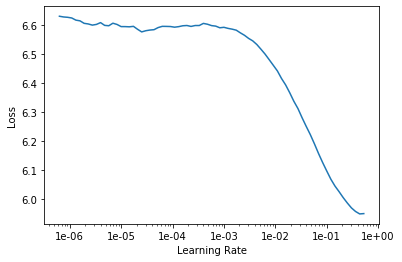

In [12]:
learn.lr_find() # Find the learning rate
learn.recorder.plot(skip_end=15) # Plot the learning rate graph

epoch,train_loss,valid_loss,accuracy,time
0,4.289134,3.872015,0.273772,00:30


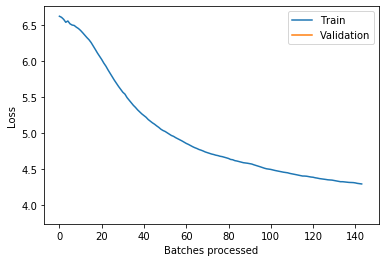

In [13]:
learn.fit_one_cycle(1, 3e-2, moms=(0.8, 0.7))

learn.recorder.plot_losses()

Let's try to make a prediction for a sentence to see how our language model has been trained

In [14]:
learn.save('lm_stage_1_new', return_path=True)

WindowsPath('C:/Users/RQ/Documents/models/lm_stage_1_new.pth')

In [15]:
learn.load('lm_stage_1_new')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (13175 items)
x: LMTextList
xxbos “ @jetblue : xxmaj our fleet 's on fleek . http : / / t.co / xxunk ” lol xxrep 5 !,xxbos “ @jetblue : xxmaj our fleet 's on fleek . http : / / t.co / xxunk ” lmao you know a white person said this,xxbos @united any help is appreciated . xxmaj that 's a xxup looong wait for help on something that 's not his fault,xxbos @jetblue i m in a xxunk presented by one of your xxunk travelers , @paulgordonbrown , i see why you love him so much http : / / t.co / xxunk,xxbos @united i take it as a compliment that i was xxunk several times as a member of your staff on my flight ... time to remove my xxunk :)
y: LMLabelList
,,,,
Path: C:\Users\RQ\Documents;

Valid: LabelList (1465 items)
x: LMTextList
xxbos @united employees almost seem happy when delivery terrible customer service .,xxbos @southwestair i got rebooked for tomorrow,xxbos @southwestair crazy how every airline flew out to the northeast tonight exce

epoch,train_loss,valid_loss,accuracy,time
0,4.196234,4.032375,0.257729,00:41
1,3.925346,3.774345,0.286551,00:41
2,3.330468,3.707745,0.298521,00:41


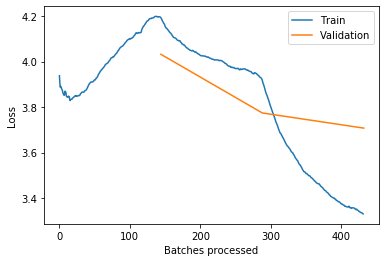

In [16]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-1/(2.6**4), 1e-1), moms=(0.8,0.7))

learn.recorder.plot_losses()

In [17]:
learn.save('lm_fine_tuned', return_path=True)

WindowsPath('C:/Users/RQ/Documents/models/lm_fine_tuned.pth')

In [18]:
learn.load('lm_fine_tuned')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (13175 items)
x: LMTextList
xxbos “ @jetblue : xxmaj our fleet 's on fleek . http : / / t.co / xxunk ” lol xxrep 5 !,xxbos “ @jetblue : xxmaj our fleet 's on fleek . http : / / t.co / xxunk ” lmao you know a white person said this,xxbos @united any help is appreciated . xxmaj that 's a xxup looong wait for help on something that 's not his fault,xxbos @jetblue i m in a xxunk presented by one of your xxunk travelers , @paulgordonbrown , i see why you love him so much http : / / t.co / xxunk,xxbos @united i take it as a compliment that i was xxunk several times as a member of your staff on my flight ... time to remove my xxunk :)
y: LMLabelList
,,,,
Path: C:\Users\RQ\Documents;

Valid: LabelList (1465 items)
x: LMTextList
xxbos @united employees almost seem happy when delivery terrible customer service .,xxbos @southwestair i got rebooked for tomorrow,xxbos @southwestair crazy how every airline flew out to the northeast tonight exce

In [19]:
TEXT = "I liked this airline because"
N_WORDS = 40
N_SENTENCES = 2
print("\n.".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

learn.save_encoder('twitter-sentiment-enc')

I liked this airline because of this . No one knows what country is to fly for me . xxbos @usairways Another problem with your planes . You know that a different chance ... But that 's not an excuse for
.I liked this airline because of your wait time for a flight to be Cancelled Flighted . xxbos @united NOT a GOOD DAY FOR DELAYS OVER THE LONG TIME ! Delayed AGAIN


### Classification Model

We have our language model ready and encoder saved, so now we create the text classification model, load the saved encoder and train the model.

In [20]:
# Create the model and load the saved encoder
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5)
learn.load_encoder('twitter-sentiment-enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (11711 items)
x: TextList
xxbos @united bummer but thank you for the quick response,xxbos @usairways i appreciate the hard work . xxmaj still , i gave up after > hour . xxunk,xxbos @united is the biggest joke of a company , i will never fly with them again ! 3 days now waiting for my bag , they do n't even know where it is !,xxbos @southwestair hey southwest ! xxmaj help me find a flight from xxmaj nashville - xxmaj washington xxup dc or xxmaj raleigh for under $ 150 on xxmaj march 15 please !,xxbos @usairways xxmaj you all work hard at making sure things xxunk smoothly . xxmaj keeping positive .
y: CategoryList
positive,negative,negative,neutral,positive
Path: C:\Users\RQ\Documents;

Valid: LabelList (2929 items)
x: TextList
xxbos @usairways thank you finally got our bag . xxmaj customer services reps were wonderful .,xxbos @jetblue need flight to xxup ath from xxup pdx . xxmaj do you coordinate with other airlines ?,xxbos @american

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


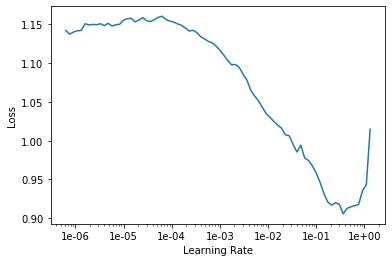

In [21]:
learn.lr_find() # Find learning rate
learn.recorder.plot() # Plot learning rate

In [22]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.587932,0.509995,0.801639,03:36


In [23]:
learn.save('clas_stage1')

In [24]:
learn.load('clas_stage1')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (11711 items)
x: TextList
xxbos @united bummer but thank you for the quick response,xxbos @usairways i appreciate the hard work . xxmaj still , i gave up after > hour . xxunk,xxbos @united is the biggest joke of a company , i will never fly with them again ! 3 days now waiting for my bag , they do n't even know where it is !,xxbos @southwestair hey southwest ! xxmaj help me find a flight from xxmaj nashville - xxmaj washington xxup dc or xxmaj raleigh for under $ 150 on xxmaj march 15 please !,xxbos @usairways xxmaj you all work hard at making sure things xxunk smoothly . xxmaj keeping positive .
y: CategoryList
positive,negative,negative,neutral,positive
Path: C:\Users\RQ\Documents;

Valid: LabelList (2929 items)
x: TextList
xxbos @usairways thank you finally got our bag . xxmaj customer services reps were wonderful .,xxbos @jetblue need flight to xxup ath from xxup pdx . xxmaj do you coordinate with other airlines ?,xxbos @american

In [25]:
# Unfreeze one layer and train another epoch
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-3/2., 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.554843,0.477705,0.815637,03:56


In [26]:
learn.save('clas_stage2', return_path=True)

WindowsPath('C:/Users/RQ/Documents/models/clas_stage2.pth')

In [27]:
learn.load('clas_stage2')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (11711 items)
x: TextList
xxbos @united bummer but thank you for the quick response,xxbos @usairways i appreciate the hard work . xxmaj still , i gave up after > hour . xxunk,xxbos @united is the biggest joke of a company , i will never fly with them again ! 3 days now waiting for my bag , they do n't even know where it is !,xxbos @southwestair hey southwest ! xxmaj help me find a flight from xxmaj nashville - xxmaj washington xxup dc or xxmaj raleigh for under $ 150 on xxmaj march 15 please !,xxbos @usairways xxmaj you all work hard at making sure things xxunk smoothly . xxmaj keeping positive .
y: CategoryList
positive,negative,negative,neutral,positive
Path: C:\Users\RQ\Documents;

Valid: LabelList (2929 items)
x: TextList
xxbos @usairways thank you finally got our bag . xxmaj customer services reps were wonderful .,xxbos @jetblue need flight to xxup ath from xxup pdx . xxmaj do you coordinate with other airlines ?,xxbos @american

In [28]:
# Unfreeze another layer
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/2., 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.523451,0.450395,0.831342,04:05


In [29]:
learn.save('clas_stage3', return_path=True)

WindowsPath('C:/Users/RQ/Documents/models/clas_stage3.pth')

In [30]:
learn.load('clas_stage3')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (11711 items)
x: TextList
xxbos @united bummer but thank you for the quick response,xxbos @usairways i appreciate the hard work . xxmaj still , i gave up after > hour . xxunk,xxbos @united is the biggest joke of a company , i will never fly with them again ! 3 days now waiting for my bag , they do n't even know where it is !,xxbos @southwestair hey southwest ! xxmaj help me find a flight from xxmaj nashville - xxmaj washington xxup dc or xxmaj raleigh for under $ 150 on xxmaj march 15 please !,xxbos @usairways xxmaj you all work hard at making sure things xxunk smoothly . xxmaj keeping positive .
y: CategoryList
positive,negative,negative,neutral,positive
Path: C:\Users\RQ\Documents;

Valid: LabelList (2929 items)
x: TextList
xxbos @usairways thank you finally got our bag . xxmaj customer services reps were wonderful .,xxbos @jetblue need flight to xxup ath from xxup pdx . xxmaj do you coordinate with other airlines ?,xxbos @american

In [31]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.431973,0.452873,0.827928,04:22
1,0.398043,0.454991,0.832025,04:34
2,0.358073,0.462027,0.829976,04:02
3,0.320301,0.474715,0.830659,04:18
4,0.278828,0.513979,0.832025,04:15
5,0.247185,0.520678,0.831342,04:01
6,0.229534,0.534841,0.830659,04:54
7,0.192789,0.550654,0.833732,04:26
8,0.193711,0.584813,0.832025,03:54
9,0.159448,0.549215,0.829293,04:36


In [32]:
learn.save('clas_stage4', return_path=True)

WindowsPath('C:/Users/RQ/Documents/models/clas_stage4.pth')

In [33]:
learn.load('clas_stage4')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (11711 items)
x: TextList
xxbos @united bummer but thank you for the quick response,xxbos @usairways i appreciate the hard work . xxmaj still , i gave up after > hour . xxunk,xxbos @united is the biggest joke of a company , i will never fly with them again ! 3 days now waiting for my bag , they do n't even know where it is !,xxbos @southwestair hey southwest ! xxmaj help me find a flight from xxmaj nashville - xxmaj washington xxup dc or xxmaj raleigh for under $ 150 on xxmaj march 15 please !,xxbos @usairways xxmaj you all work hard at making sure things xxunk smoothly . xxmaj keeping positive .
y: CategoryList
positive,negative,negative,neutral,positive
Path: C:\Users\RQ\Documents;

Valid: LabelList (2929 items)
x: TextList
xxbos @usairways thank you finally got our bag . xxmaj customer services reps were wonderful .,xxbos @jetblue need flight to xxup ath from xxup pdx . xxmaj do you coordinate with other airlines ?,xxbos @american

### Testing out our Sentiment Analysis
Let's try testing this out with a positive, neutral and negative statement to see if the classification works

In [34]:
learn.predict("I really loved the flight")

C:\Users\RQ\Anaconda3\envs\fastai_v1\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category positive, tensor(2), tensor([0.0973, 0.0034, 0.8993]))

In [35]:
learn.predict("That flight was okay")

C:\Users\RQ\Anaconda3\envs\fastai_v1\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category neutral, tensor(1), tensor([0.0098, 0.9382, 0.0520]))

In [36]:
learn.predict("I hated that flight, it was horrible")

C:\Users\RQ\Anaconda3\envs\fastai_v1\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category negative, tensor(0), tensor([0.7349, 0.2599, 0.0052]))